In [ ]:
##### library imports ##### 

# preprocessing and splitting data packages
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# modeling data packages
import keras
import tensorflow as tf
import keras_tuner as kt
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Preprocess Data from Preprocessing file

In [1]:
my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 200 # good starting point to train model
seed = 42 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
All data have the same shape
Combined data and labels shape: (800, 256, 256, 1), (800,)


# Visually Inspect

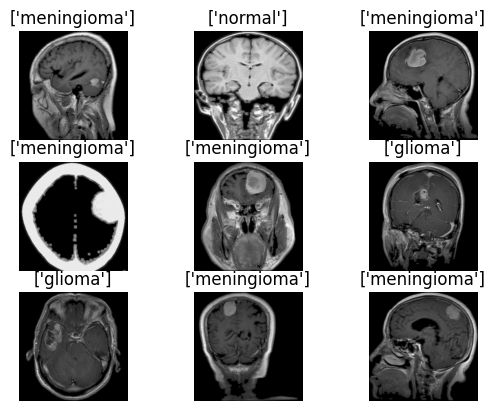

In [11]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- We first can start with a simple convolution model to see how well a few different architectures will pick up on the training data set,
- Then we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.

# Simple CNN to Start

### What is a CNN?
A CNN (convolutional neural network) is a type of network that specializes in processing and predicting grid-like data, making it especially useful for image classification. It utilizes automatic detection of spatial hierarchies and patterns with layers of convolutional filters. Unlike the classic feed-forward network, which connects each neuron to every neuron in the next layer, a CNN uses local receptive fields and shared weights in its convolutional layers, which reduces the number of parameters significantly, and improves the efficiency of the model. 

### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [21]:
# Initialize model
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 1)),
  MaxPooling2D(2), # reduce dimensionality
  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(2), # reduce dimensionality
  Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(2), # reduce dimensionality
  Flatten(), # flatten the data to feed into the dense layers
  Dense(units=128, activation='relu'),
  Dropout(0.5), # prevent overfitting
  Dense(units=4, activation='softmax') # output layer
])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,857,668 (56.68 MB)

 Trainable params: 14,857,668 (56.68 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3666 - loss: 1.3450 - val_accuracy: 0.4437 - val_loss: 1.3371
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4033 - loss: 1.3310 - val_accuracy: 0.4563 - val_loss: 1.3145
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4600 - loss: 1.2980 - val_accuracy: 0.4875 - val_loss: 1.2798
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5018 - loss: 1.2632 - val_accuracy: 0.3875 - val_loss: 1.2620
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4921 - loss: 1.2193 - val_accuracy: 0.5063 - val_loss: 1.2026
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4765 - loss: 1.1730 - val_accuracy: 0.5813 - val_loss: 1.1571
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5376 - loss: 1.1224 - val_accuracy: 0.5063 - val_loss: 1.1243
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5221 - loss: 1.0925 - val_accuracy: 0.5562 - val_loss:

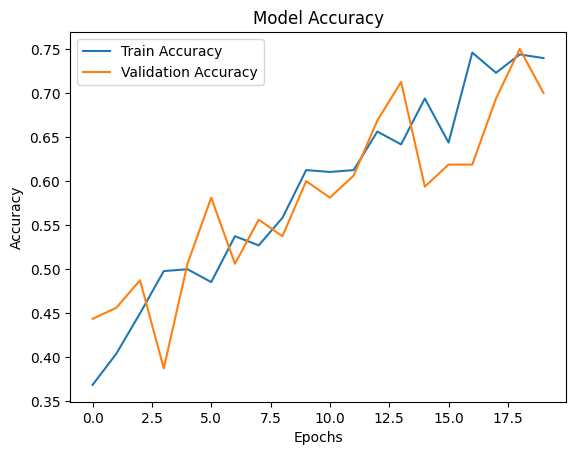

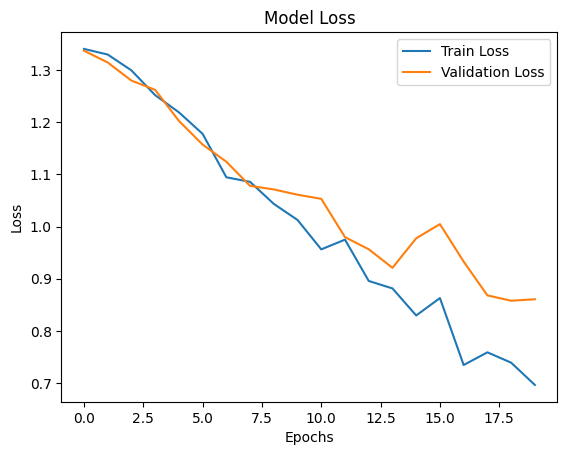

In [8]:
K.clear_session()

# Train the model # 

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_small,
    train_small_labels,
    validation_data=(val_data, val_labels), # Convert sparse matrix
    epochs=20,
    batch_size=32, # mini batch size
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
# TODO: 
# mini batch sampling and gradient descent to see how the model could be improved
# Try out different architectures and see how they perform using hyperparameter tuning

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- Using Hyperband from kerastuners, we can define a function to build the best model.
- After finding the best model, we can then build a new model to train.

In [4]:
# building a hyperband model to find the best model architecture
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                     activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D(2), # max pooling to reduce the dimensionality of the data
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                     activation='relu'),
        MaxPooling2D(2), # max pooling to reduce the dimensionality of the data
        Flatten(), # flatten the data to feed into the dense layers
        Dense(units=hp.Int('dense_1_units', min_value=64, max_value=256, step=32), # find the best number of units
                    activation='relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)), # dropout to prevent overfitting
        Dense(4, activation='softmax') # pituitary, meningioma, glioma, normal
    ])
    # compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), # find the best learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# tuning using the validation set
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=30, factor=5, directory=my_dir, project_name='Hyperband_tuning')
tuner.search(train_small, train_small_labels, epochs=5, validation_data=(val_data, val_labels))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 18 Complete [00h 01m 11s]
val_accuracy: 0.28125

Best val_accuracy So Far: 0.5625
Total elapsed time: 00h 25m 36s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
112               |128               |conv_1_filter
5                 |5                 |conv_1_kernel
112               |112               |conv_2_filter
5                 |3                 |conv_2_kernel
256               |256               |dense_1_units
0.4               |0.2               |dropout_1
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Once we have our best model, we can then build using the best architecture and train on the full data set.